In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import old_references.nonlinear_QM_FPJPA as Fs
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import standard_sequences.rabi_ef_no_swap as rabi_ef_no_swap
import standard_sequences.rabi_tomo as tomo
import classifiers.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import joblib
import time
import traceback
from scipy.signal import savgol_filter

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
 # offset to sweet spot

Qubit(ge_amp=1.01, qubit_id=q1, IQ_angle=60, ro_freq=6.72739, qubit_thr=[-10000, -600], ro_dur=5000, ef_time=44, RO_LO=6.6247, RO_LO_pwr=16, ef_ssm=-0.25684, RO_IF=None, ROIF=0.10268999999999995, mixer_offset_ef=6, ro_amp=0.25, ge_time=77, mixer_offset_ge=2.5, ge_ssm=-0.1144, ef_half_time=25, ef_amp=1.5, ef_half_amp=1.3)
Qubit(ge_amp=0.4, qubit_id=q2, IQ_angle=25, ro_freq=6.65554, qubit_thr=[-10000, 1900], ro_dur=5000, ef_time=None, RO_LO=6.6247, RO_LO_pwr=16, ef_ssm=-0.2962, RO_IF=None, ROIF=0.030840000000000423, mixer_offset_ef=None, ro_amp=0.45, ge_time=74, mixer_offset_ge=None, ge_ssm=-0.154, ef_half_time=None, ef_amp=1, ef_half_amp=None)


In [3]:
a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / q1.ef_amp
        # if J is in units of rad/micros
J_to_a = 1 / a_to_J

In [4]:
def correct_probabilities_over_time(M: np.ndarray,
                                    P_measured_mat: np.ndarray
                                   ) -> np.ndarray:
    """
    Perform constrained least-squares inversion on each column of P_measured_mat.
    
    Args:
        M:             (3×3) scale/assignment matrix.
        P_measured_mat:(3×N) measured probability columns.
    
    Returns:
        P_true_mat:   (3×N) corrected, physical probability columns.
    """
    num_levels, num_times = P_measured_mat.shape
    assert M.shape == (num_levels, num_levels), "M must be square of size 3"
    
    # Prepare output
    P_true_mat = np.zeros_like(P_measured_mat)
    
    # Common settings
    bounds = [(0, 1)] * num_levels
    constraint = {'type': 'eq', 'fun': lambda P: np.sum(P) - 1}

    # Loss function factory
    def make_loss(P_meas):
        return lambda P_true: np.linalg.norm(M @ P_true - P_meas)**2

    # Loop over each time index
    for i in range(num_times):
        P_meas = P_measured_mat[:, i]
        loss = make_loss(P_meas)
        x0 = np.ones(num_levels) / num_levels  # uniform initial guess
        
        res = minimize(loss,
                       x0,
                       bounds=bounds,
                       constraints=[constraint])
        
        if not res.success:
            raise RuntimeError(f"Optimization failed at column {i}: {res.message}")
        
        P_true_mat[:, i] = res.x
    
    return P_true_mat

In [5]:
def run_rabi_tomo(
    q1,
    q2,
    general_vals_dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
    tomography: str,
    state:str,
    rabi_freq: float,
    drive_amp: float,
    y_phase: float,
    x_phase: float,
    load_sequence:int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    
    # Run the experiment
    if load_sequence == 0:
        pass
    elif load_sequence == 1:
        tomo.rabi_ef_swap_tomo(
        q1,
        q2,
        general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        drive_amp=drive_amp,
        tomo_comp=tomography,
        state_comp=state,
        rabi_freq=rabi_freq,
        y_phase=y_phase,
        x_phase=x_phase,
        
    )
    

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values


def sweep_J(J_list: list):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.

    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    probs_folder = os.path.join("sweep_J_data", "probs")
    values_folder = os.path.join("sweep_J_data", "values")
    os.makedirs(probs_folder, exist_ok=True)
    os.makedirs(values_folder, exist_ok=True)
    num_steps = 81
    reps = 8000
    sweep_time = 20000
    swap_freq = -0.0194
    swap_time = 0.5 * 7 / abs(swap_freq)

    # Create an array of frequency values
    J_vals = J_list

    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    return_dict = {}
    return_vals = {}

    tomography="z"
    state="e"
    rabi_freq=q1.ef_ssm
    y_phase=0
    x_phase=0
    # Loop over frequencies and populate the dictionary
    for J in J_vals:
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # If both files already exist, load them and skip this iteration
        if os.path.exists(prob_filename) and os.path.exists(values_filename):
            with open(prob_filename, "rb") as f:
                df_prob = pickle.load(f)
            with open(values_filename, "rb") as f:
                values = pickle.load(f)
            return_dict[J] = df_prob
            return_vals[J] = values
            continue  # Skip to the next J value
        drive_amp = J * J_to_a
        tomography="z"
        state="e"
        rabi_freq=q1.ef_ssm
        y_phase=0
        x_phase=0
        load_sequence=1
        df_prob, df_pop, values = run_rabi_tomo(
            q1, q2, general_vals_dict,
            num_steps, sweep_time, swap_freq, swap_time,
            reps, tomography, state,
            rabi_freq, drive_amp, y_phase, x_phase,
            load_sequence
        )
        # Populate the dictionary at the corresponding frequency key
        return_dict[J] = df_prob
        return_vals[J] = values

        # Create filenames with the current J value
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # Save df_prob to a pickle file
        with open(prob_filename, "wb") as f:
            pickle.dump(df_prob, f)
            del df_prob
        # Save values to a pickle file
        with open(values_filename, "wb") as f:
            pickle.dump(values, f)
            del values
    return return_dict, return_vals

In [6]:
J_start = 0
J_stop = 1.5
J_steps = 151
# J_list = np.linspace(10, 10,1)#
J_list =np.linspace(J_start, J_stop, J_steps)
# Main loop: if an error occurs, print it, wait, and restart
while True:
    try:
        
        J_dict, vals_dict = sweep_J(J_list)
        break  # Exit loop when measurements complete successfully
    except Exception as e:
        print("An error occurred:")
        traceback.print_exc()
        print("Restarting in 5 seconds...")
        time.sleep(5)


In [7]:
probs_folder = os.path.join("sweep_J_data", "probs")
values_folder = os.path.join("sweep_J_data", "values")
scale_matrix= joblib.load("classifiers/scale_matrix.pkl")
probability_dataframes = {}
for J in J_list:
    prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
    values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

    # If both files already exist, load them and skip this iteration
    if os.path.exists(prob_filename) and os.path.exists(values_filename):
        with open(prob_filename, "rb") as f:
            df_prob = pickle.load(f)
            P_matrix=np.array([df_prob["P_g"], df_prob["P_e"], df_prob["P_f"]])
            P_matrix_scaled =correct_probabilities_over_time(scale_matrix, P_matrix)
            df_prob_scaled = pd.DataFrame(
                {
                    "time": df_prob["time"],
                    "P_f": P_matrix_scaled[2],
                    "P_e": P_matrix_scaled[1],
                    "P_g": P_matrix_scaled[0],
                },
                index=df_prob["time"],
            )

    probability_dataframes[J] = df_prob_scaled



In [19]:
def sweep_J_curve_fit(probability_dataframes):
    """
    Loops over each J in the probability_dataframes dictionary, performs a
    renormalization and curve fit on the P_f data, and returns a dictionary
    mapping J values to the extracted Rabi angular frequency.

    Parameters:
        probability_dataframes (dict): Dictionary with keys as J values and values as
                                       DataFrames containing columns 'time', 'P_f', 'P_e', etc.
        guess_gamma (float): Initial guess for gamma used in the curve fit for J <= 0.25.
        guess_freq (float): Initial guess for frequency used in the curve fit for J > 0.25.

    Returns:
        omega_values (dict): Dictionary mapping each J value to its extracted angular frequency
                             in rad/µs.
    """
    omega_values = {}

    for J, df in probability_dataframes.items():
        # Extract the time and state probability data from the DataFrame
        times = df["time"].values
        P_f = df["P_f"].values
        P_e = df["P_e"].values
        # print(J)
        # Renormalize: P_f_norm = P_f / (P_f + P_e)
        norm_factor = P_f + P_e
        # Avoid division by zero (if that case can ever occur)
        norm_factor[norm_factor == 0] = 1

        guess_gamma =np.sqrt( abs(0.14**2 - J**2))
        guess_freq = np.sqrt(abs(0.14**2 - J**2)) / np.pi
   
        if J <= 0.28:
            # Apply Savitzky-Golay filter
            window_length = 21  # must be odd; try 7, 9, 11, ...
            poly_order = 3     # polynomial order
            P_f_norm  = savgol_filter(P_f , window_length, poly_order)#P_f#/ norm_factor
            lower_bounds = [0, 0.4,0, 0, -np.inf]
            upper_bounds = [.01,0.6,20, np.inf, np.inf]
            guess_vals = [0.01, .53,13, 0, 0.025]
        else:
            P_f_norm = P_f #/  norm_factor
            lower_bounds = [0, 0.4,0, -np.inf, -np.inf]
            upper_bounds = [.3,0.6,np.inf, np.inf, np.inf]
            guess_vals = [0, 0.5, (J/np.sqrt(abs(0.2**2 - J**2)) )**2, 0, 0.02]#0,0.55  , 
        # guess_vals = [0, guess_gamma, 0.1, -10, 0.03]
        # Perform the curve fit using analysis.fit_sine_decay.
        # It is assumed that this function returns a tuple where the first element
        # is an array of fit parameters, with the first parameter corresponding to frequency.
        fit_vals_f, _, _, _ = analysis.fit_sine_square_decay(
            times, P_f_norm, guess_vals=guess_vals,lower_bounds=lower_bounds,upper_bounds=upper_bounds
            
        )

        # Calculate the angular frequency: omega = |(freq * 2π)|
        omega_rabi_f = abs(fit_vals_f[0] * 2 * np.pi)

        print(f"J = {J}: Angular freq (rad/µs): {omega_rabi_f}")
        omega_values[J] = omega_rabi_f

    return omega_values

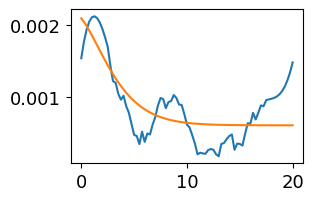

freq:0.009999999999970179,gamma: 0.5999999999999999, amp:0.023166156901296444, phase_deg: 14.626903741824554,offset: 0.0006142779851881004,
J = 0.0: Angular freq (rad/µs): 0.06283185307160849


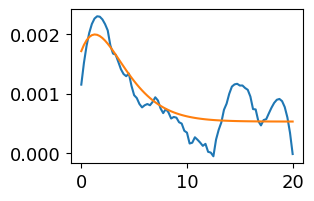

freq:0.009999999775384745,gamma: 0.5999999999999999, amp:0.07531954666093489, phase_deg: 7.201543015865738,offset: 0.0005314598348229711,
J = 0.01: Angular freq (rad/µs): 0.0628318516604966


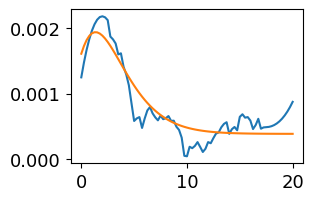

freq:0.00999999998990897,gamma: 0.5999999999999999, amp:0.08276133118871985, phase_deg: 6.973267660828665,offset: 0.0003863882336295323,
J = 0.02: Angular freq (rad/µs): 0.06283185300839204


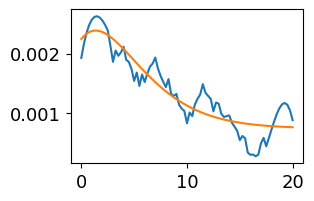

freq:0.00039182496647703494,gamma: 0.4000000000000001, amp:18.679809556596904, phase_deg: 0.5145372721507424,offset: 0.0007406727151239858,
J = 0.03: Angular freq (rad/µs): 0.00246190887235464


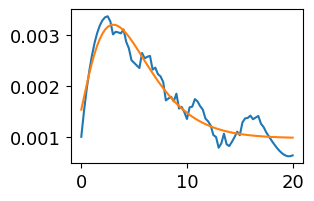

freq:0.000939145911288629,gamma: 0.5065964026579576, amp:18.984445297541754, phase_deg: 0.3108131528318933,offset: 0.0009812711695507312,
J = 0.04: Angular freq (rad/µs): 0.005900827791106497


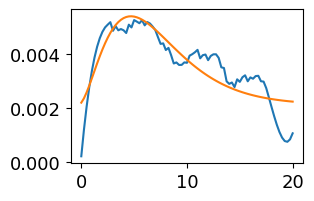

freq:0.001042728555545801,gamma: 0.4000000000000001, amp:19.999570893025354, phase_deg: 0.11444262194944423,offset: 0.002130202345003737,
J = 0.05: Angular freq (rad/µs): 0.00655165673958197


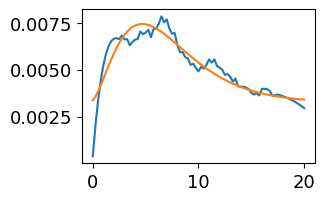

freq:0.001176124078250187,gamma: 0.4000000000000001, amp:19.99999999990899, phase_deg: 0.1311917423164392,offset: 0.003260466365123481,
J = 0.06: Angular freq (rad/µs): 0.007389805527881708


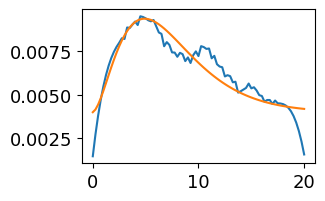

freq:0.0013945973465335465,gamma: 0.4000000000000001, amp:19.99932016834839, phase_deg: 0.04932896387842288,offset: 0.003987627510975258,
J = 0.07: Angular freq (rad/µs): 0.008762513557171217


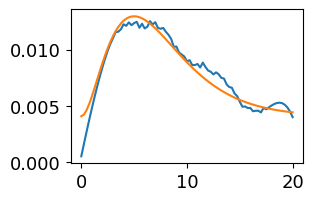

freq:0.0018224195943650722,gamma: 0.4000000000000001, amp:19.999999993299898, phase_deg: 1.7954580764850965e-44,offset: 0.004089916923408135,
J = 0.08: Angular freq (rad/µs): 0.011450600018830803


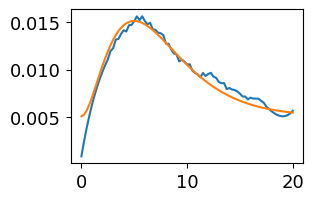

freq:0.0019451460861290408,gamma: 0.4000000000000001, amp:19.99644584692844, phase_deg: 3.862219726924422e-48,offset: 0.005054473935406023,
J = 0.09: Angular freq (rad/µs): 0.012221713308683867


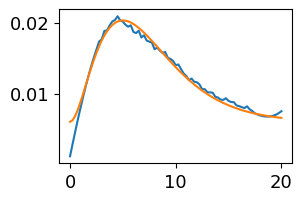

freq:0.0023170025175169983,gamma: 0.4000000000000001, amp:19.99999976935015, phase_deg: 3.353116181517912e-47,offset: 0.0060053280419974184,
J = 0.1: Angular freq (rad/µs): 0.014558156174760915


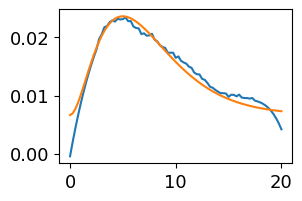

freq:0.0025230887504778168,gamma: 0.4000000000000001, amp:19.9999999996079, phase_deg: 4.038022862563915e-39,offset: 0.006654039080946565,
J = 0.11: Angular freq (rad/µs): 0.01585303416571232


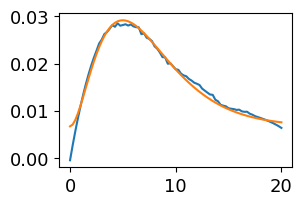

freq:0.0029045998681537155,gamma: 0.4000000000000001, amp:19.99996320071113, phase_deg: 1.0213218739513972e-38,offset: 0.006704135732926287,
J = 0.12: Angular freq (rad/µs): 0.01825013921481919


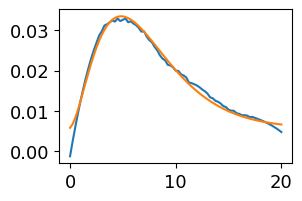

freq:0.003137579634027544,gamma: 0.4000000000000001, amp:19.999999999996326, phase_deg: 0.1692381088116305,offset: 0.005672843673210404,
J = 0.13: Angular freq (rad/µs): 0.01971399425662777


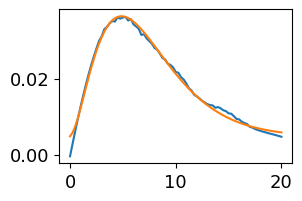

freq:0.003368128222943246,gamma: 0.4000000000000001, amp:19.999999999963254, phase_deg: 0.1459485431290043,offset: 0.00473308689550439,
J = 0.14: Angular freq (rad/µs): 0.021162573763093894


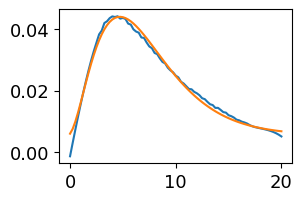

freq:0.003699261162021657,gamma: 0.4047990304217938, amp:19.998058842333414, phase_deg: 0.27490979984524405,offset: 0.005486722605491683,
J = 0.15: Angular freq (rad/µs): 0.02324314338063456


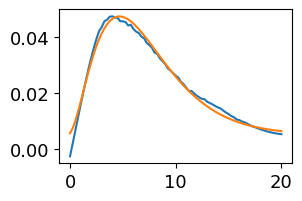

freq:0.0038847124950088536,gamma: 0.4074441005949231, amp:19.999999998863824, phase_deg: 0.29867054862159975,offset: 0.0050807046507227414,
J = 0.16: Angular freq (rad/µs): 0.024408368471256582


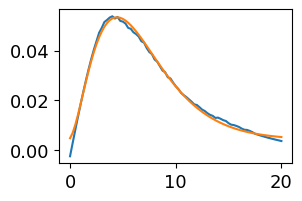

freq:0.004431616392219279,gamma: 0.42928943333913694, amp:19.997913416107693, phase_deg: 0.30840429208541414,offset: 0.0041566066469980005,
J = 0.17: Angular freq (rad/µs): 0.02784466700264838


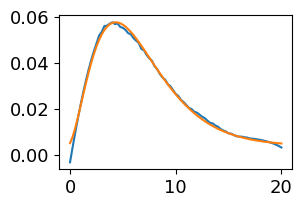

freq:0.004609667988339065,gamma: 0.43365604868963875, amp:19.975382955730424, phase_deg: 0.44203806062927214,offset: 0.003774407214734982,
J = 0.18: Angular freq (rad/µs): 0.028963398175308092


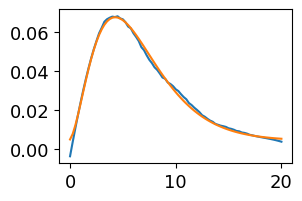

freq:0.005256950251160349,gamma: 0.4470642772316146, amp:19.9999443219609, phase_deg: 0.3225626937217406,offset: 0.0042836745025335455,
J = 0.19: Angular freq (rad/µs): 0.03303039257866474


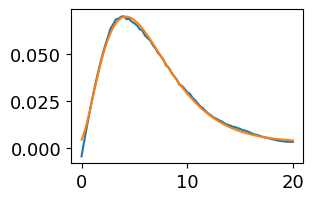

freq:0.0052834704703100125,gamma: 0.4450456289114297, amp:19.999999999177852, phase_deg: 0.48954833753910737,offset: 0.0030692982778094515,
J = 0.2: Angular freq (rad/µs): 0.03319702402996909


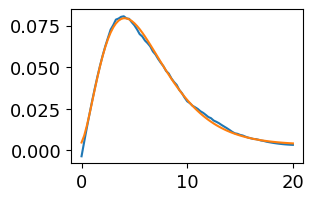

freq:0.005857126102453945,gamma: 0.4604875577285698, amp:19.99993552837861, phase_deg: 0.4846561076633034,offset: 0.0033332355138641343,
J = 0.21: Angular freq (rad/µs): 0.03680140866923667


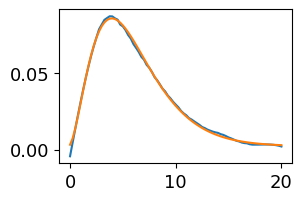

freq:0.00647958941521074,gamma: 0.48118212115831793, amp:19.99945955824737, phase_deg: 0.4019676003027066,offset: 0.0022713430962025064,
J = 0.22: Angular freq (rad/µs): 0.040712461010208485


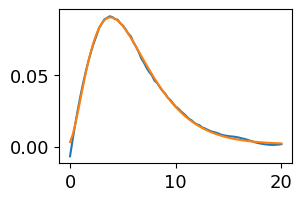

freq:0.006736814426387517,gamma: 0.49077454222312955, amp:19.999999999999996, phase_deg: 0.5054230444150472,offset: 0.001726655878986889,
J = 0.23: Angular freq (rad/µs): 0.04232865342107352


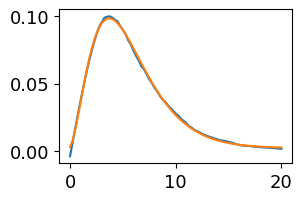

freq:0.007532250950527327,gamma: 0.5157165693014618, amp:19.999992319307676, phase_deg: 0.3589849246531459,offset: 0.002058031153624087,
J = 0.24: Angular freq (rad/µs): 0.04732652850234277


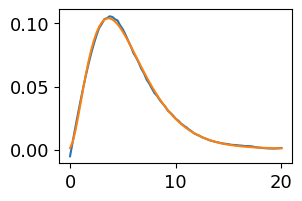

freq:0.009998790253770092,gamma: 0.5265249613598522, amp:12.987005993500391, phase_deg: 0.33921725428631677,offset: 0.0008078881488528255,
J = 0.25: Angular freq (rad/µs): 0.06282425201205868


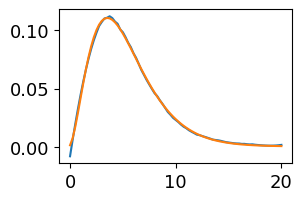

freq:0.009999999988889214,gamma: 0.5356110337479769, amp:13.969324375061552, phase_deg: 0.4868491851550395,offset: 0.0006525962683627674,
J = 0.26: Angular freq (rad/µs): 0.06283185300198474


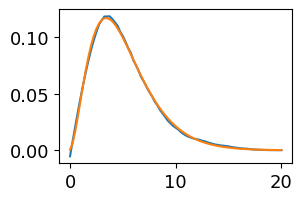

freq:0.009999889503213283,gamma: 0.5621007451602723, amp:16.73501205483945, phase_deg: 0.31679006541652766,offset: 0.00012506173898137337,
J = 0.27: Angular freq (rad/µs): 0.06283115880000907


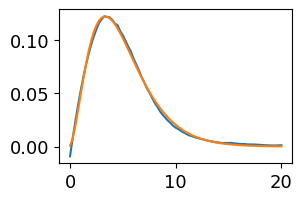

freq:0.009999998459674298,gamma: 0.5745908253191965, amp:18.142524778475693, phase_deg: 0.3609163019928951,offset: -2.921439321204046e-05,
J = 0.28: Angular freq (rad/µs): 0.06283184339364405


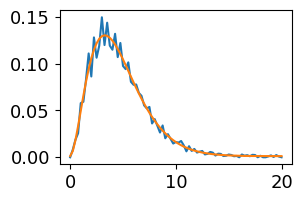

freq:0.02100822259133893,gamma: 0.5667599201932397, amp:4.620640180448842, phase_deg: 0.23573521564661942,offset: 0.0012236118921811609,
J = 0.29: Angular freq (rad/µs): 0.131998555515859


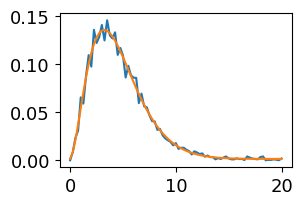

freq:0.02255461300738426,gamma: 0.5626464858533953, amp:4.07653730018942, phase_deg: 0.5399559959417904,offset: 0.0014124766466621014,
J = 0.3: Angular freq (rad/µs): 0.14171481305711836


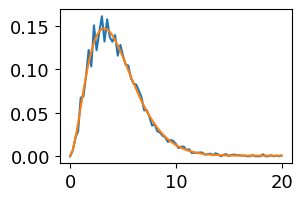

freq:0.027164434092927528,gamma: 0.550729403733631, amp:3.085050786946443, phase_deg: 0.42741724154855454,offset: 0.0007142603763585603,
J = 0.31: Angular freq (rad/µs): 0.17067917317053047


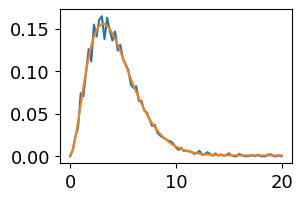

freq:0.02822732802796307,gamma: 0.5714589160468175, amp:3.299463447324557, phase_deg: 0.15051374871799023,offset: 0.001034264995927482,
J = 0.32: Angular freq (rad/µs): 0.17735753272623608


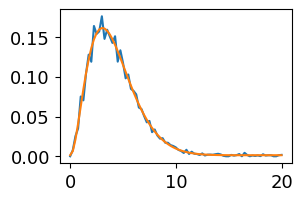

freq:0.030136148934191108,gamma: 0.5854346469313015, amp:3.240704374323139, phase_deg: -0.22622057108397647,offset: 0.0013344053371491425,
J = 0.33: Angular freq (rad/µs): 0.18935100819828532


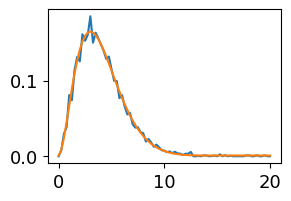

freq:0.03421416745845934,gamma: 0.5645913563053667, amp:2.431503683218381, phase_deg: 0.32958610716935216,offset: 0.0009577877920573333,
J = 0.34: Angular freq (rad/µs): 0.21497395427237362


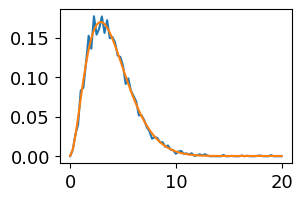

freq:0.03288492696524716,gamma: 0.5999999999999994, amp:2.9870794965559546, phase_deg: 0.31087737005853977,offset: 0.0003826723641140772,
J = 0.35000000000000003: Angular freq (rad/µs): 0.20662208993571474


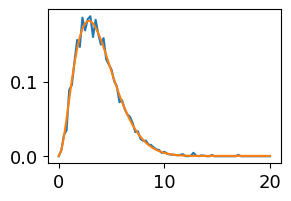

freq:0.0361508226768033,gamma: 0.5999999999999187, amp:2.760867590211281, phase_deg: -0.06649302978364627,offset: 0.00048595644285674087,
J = 0.36: Angular freq (rad/µs): 0.22714231788534509


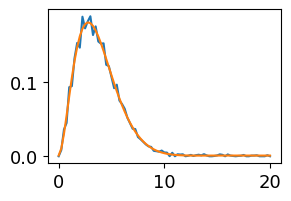

freq:0.037242148291157774,gamma: 0.5999999994597514, amp:2.534482052425815, phase_deg: 0.44888615206918275,offset: 0.0009236392064633953,
J = 0.37: Angular freq (rad/µs): 0.23399931895080586


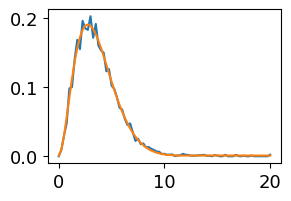

freq:0.040965491962518266,gamma: 0.5999999999999999, amp:2.3286429809289966, phase_deg: 0.12888193687441488,offset: 0.0010242272074779584,
J = 0.38: Angular freq (rad/µs): 0.25739377720027823


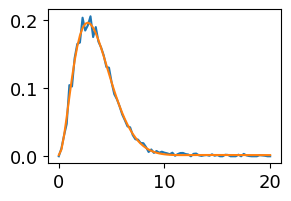

freq:0.04243698633807432,gamma: 0.5999999999999999, amp:2.2681010668037596, phase_deg: -0.10724191759456611,offset: 0.0017118121545558337,
J = 0.39: Angular freq (rad/µs): 0.2666394490403694


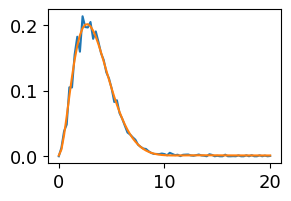

freq:0.04534461978656063,gamma: 0.5993596536428387, amp:2.0920424699339315, phase_deg: -0.007850668799263855,offset: 0.001236443212850088,
J = 0.4: Angular freq (rad/µs): 0.2849086488025625


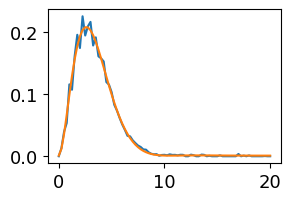

freq:0.04742169573259754,gamma: 0.5999999999987993, amp:1.9939005882976424, phase_deg: 0.33803456471682675,offset: 0.0010494587645361487,
J = 0.41000000000000003: Angular freq (rad/µs): 0.29795930186859776


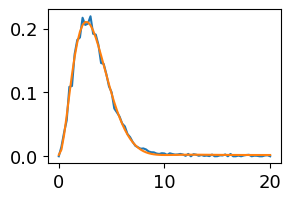

freq:0.049379971885632486,gamma: 0.5999999999999999, amp:1.9305437117060757, phase_deg: -0.37380963258621475,offset: 0.001990326880517442,
J = 0.42: Angular freq (rad/µs): 0.31026351382074707


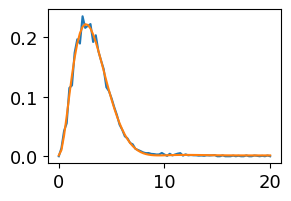

freq:0.052828752470511636,gamma: 0.5887124229042868, amp:1.788135048798177, phase_deg: -0.3693967711343062,offset: 0.0014637110557787563,
J = 0.43: Angular freq (rad/µs): 0.331932841319346


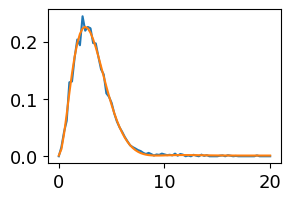

freq:0.05374208782092493,gamma: 0.5999999999998908, amp:1.798676099743281, phase_deg: 0.05971704593908447,offset: 0.0012730972461080315,
J = 0.44: Angular freq (rad/µs): 0.3376714965735905


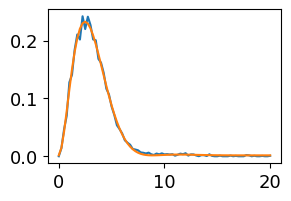

freq:0.05626997098629715,gamma: 0.5776645386916384, amp:1.6148476332574506, phase_deg: 0.4899787110466392,offset: 0.0015894702414140443,
J = 0.45: Angular freq (rad/µs): 0.3535546549365239


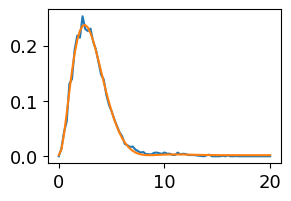

freq:0.058281280334069825,gamma: 0.5999999999999996, amp:1.6977629235062033, phase_deg: -0.39158070022541275,offset: 0.0019852789410070297,
J = 0.46: Angular freq (rad/µs): 0.3661920842786421


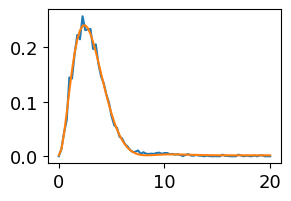

freq:0.05995328478978421,gamma: 0.5925208904527351, amp:1.6183042176595166, phase_deg: -0.2505127072008354,offset: 0.0018000185647886646,
J = 0.47000000000000003: Angular freq (rad/µs): 0.37669759810832554


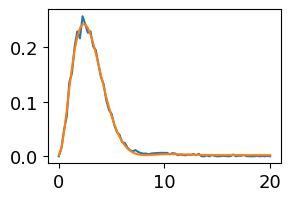

freq:0.06086448766032619,gamma: 0.5999999999999999, amp:1.6150114052671039, phase_deg: -0.014104445683335165,offset: 0.0021407751485922177,
J = 0.48: Angular freq (rad/µs): 0.38242285459637476


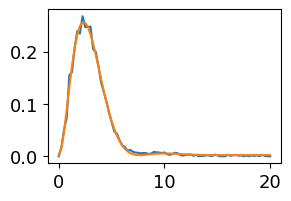

freq:0.06527224040720062,gamma: 0.5727604968228567, amp:1.4473477289345125, phase_deg: 0.06267859077795551,offset: 0.0022451631492047563,
J = 0.49: Angular freq (rad/µs): 0.4101175818932166


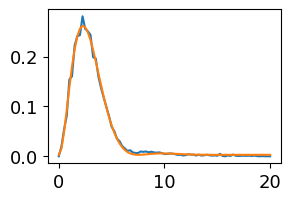

freq:0.06642478335120283,gamma: 0.5999999999999999, amp:1.5501336444718856, phase_deg: -0.43619855754658593,offset: 0.002914824699373778,
J = 0.5: Angular freq (rad/µs): 0.4173592227848648


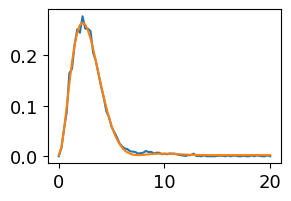

freq:0.06653508284989983,gamma: 0.5999999999999999, amp:1.5465428964279182, phase_deg: 0.2124694593278731,offset: 0.0023097452578063954,
J = 0.51: Angular freq (rad/µs): 0.4180522549744671


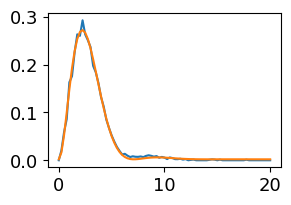

freq:0.07048964205537257,gamma: 0.5915557071351194, amp:1.4559632268359255, phase_deg: -0.16969362881536262,offset: 0.001994108320730399,
J = 0.52: Angular freq (rad/µs): 0.4428994832706652


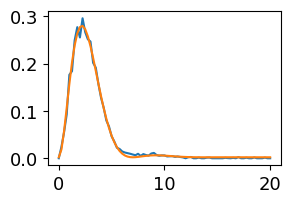

freq:0.07138255372904366,gamma: 0.5999999999999999, amp:1.4916437282612023, phase_deg: 0.072530001486838,offset: 0.0021012632860727973,
J = 0.53: Angular freq (rad/µs): 0.44850981277928453


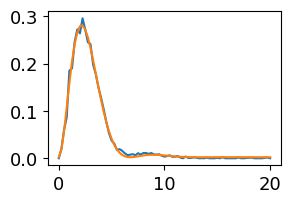

freq:0.07401700128973279,gamma: 0.5921042225061908, amp:1.4069689347140468, phase_deg: -0.039337577300609015,offset: 0.0022322467061956295,
J = 0.54: Angular freq (rad/µs): 0.46506253498514155


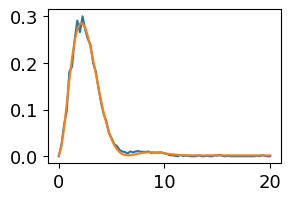

freq:0.07624103178789,gamma: 0.5685364978216109, amp:1.296515528516267, phase_deg: 0.5857844734109373,offset: 0.0019106217911323308,
J = 0.55: Angular freq (rad/µs): 0.47903653073388225


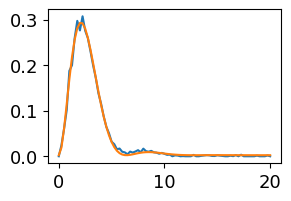

freq:0.07827492543810899,gamma: 0.5884166717926285, amp:1.3658128041230204, phase_deg: -0.20084127992794376,offset: 0.002359410181932192,
J = 0.56: Angular freq (rad/µs): 0.491815861433304


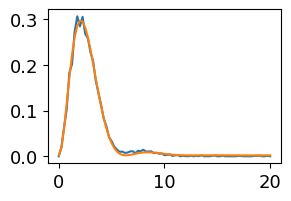

freq:0.07914867167489016,gamma: 0.5999999999985388, amp:1.4109560929503895, phase_deg: -0.5347617380728406,offset: 0.002034115098989667,
J = 0.5700000000000001: Angular freq (rad/µs): 0.497305770950451


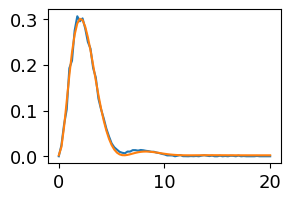

freq:0.08112772375894599,gamma: 0.582919946576049, amp:1.3202829486378265, phase_deg: -0.03394683599285332,offset: 0.002142043035673328,
J = 0.58: Angular freq (rad/µs): 0.5097405219271337


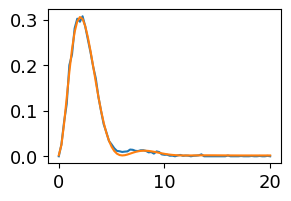

freq:0.08267222803165959,gamma: 0.5570348775389433, amp:1.2215185670348967, phase_deg: 1.0627328198199049,offset: 0.0018039960613085862,
J = 0.59: Angular freq (rad/µs): 0.5194449284803239


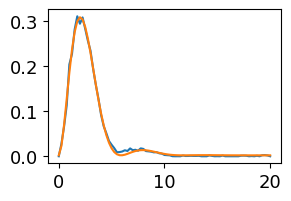

freq:0.08467550198238195,gamma: 0.5544934830050007, amp:1.2027680926466449, phase_deg: 0.537186977550806,offset: 0.002088674791920648,
J = 0.6: Angular freq (rad/µs): 0.5320318699337582


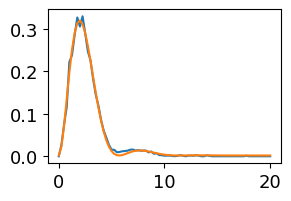

freq:0.08763408115839744,gamma: 0.5766208736393686, amp:1.2642192324681336, phase_deg: 0.07651292080280976,offset: 0.0018494230523484635,
J = 0.61: Angular freq (rad/µs): 0.5506211711426262


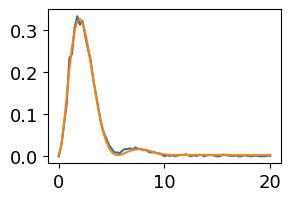

freq:0.08914133620558487,gamma: 0.559850698550052, amp:1.2090953494709122, phase_deg: 0.6972363923322215,offset: 0.002758081690370023,
J = 0.62: Angular freq (rad/µs): 0.5600915339092866


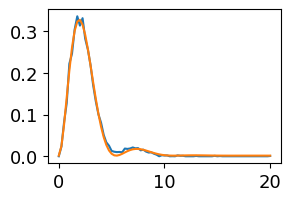

freq:0.09188851566806167,gamma: 0.5519352381611328, amp:1.1697925943247092, phase_deg: 0.34387332071488785,offset: 0.0015287379784965345,
J = 0.63: Angular freq (rad/µs): 0.5773525715441062


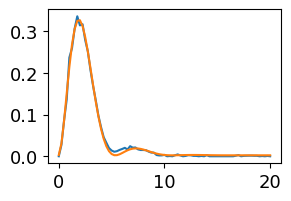

freq:0.092563037059671,gamma: 0.5502904037109548, amp:1.1316017362239863, phase_deg: 1.4325045888227272,offset: 0.0023072584693507626,
J = 0.64: Angular freq (rad/µs): 0.5815907144412444


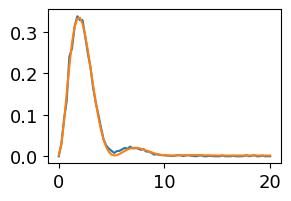

freq:0.09400119810232987,gamma: 0.5416439385382784, amp:1.1289387135074271, phase_deg: 1.170945467482251,offset: 0.0018755041464609086,
J = 0.65: Angular freq (rad/µs): 0.5906269467738366


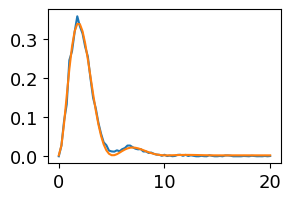

freq:0.09752642397313345,gamma: 0.5512174117822216, amp:1.1326990692127552, phase_deg: 0.4260217892022372,offset: 0.0023557422519159183,
J = 0.66: Angular freq (rad/µs): 0.612776594169759


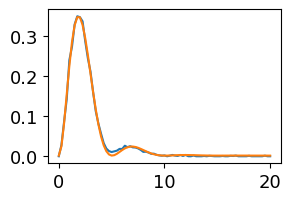

freq:0.09919492333579016,gamma: 0.5412216449095477, amp:1.1348422958768996, phase_deg: -0.10546931446067531,offset: 0.0016534485479261219,
J = 0.67: Angular freq (rad/µs): 0.6232600848502422


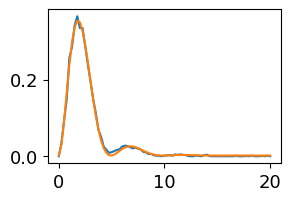

freq:0.10097659548608527,gamma: 0.5407651286420367, amp:1.115638676566232, phase_deg: 0.7186671480546877,offset: 0.0018470508764033093,
J = 0.68: Angular freq (rad/µs): 0.6344546611271875


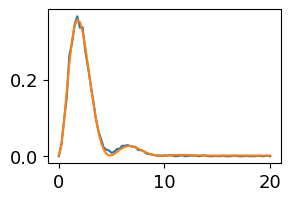

freq:0.10265078648796558,gamma: 0.5440629601367339, amp:1.1111315579407988, phase_deg: 0.6769680164203371,offset: 0.0018441463924664446,
J = 0.6900000000000001: Angular freq (rad/µs): 0.6449739134316141


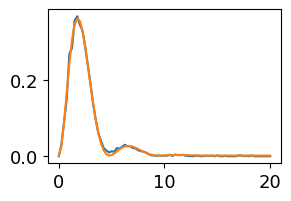

freq:0.10443613766855228,gamma: 0.5525468237311678, amp:1.1438898951092313, phase_deg: -0.32669767749983564,offset: 0.0017904222776969298,
J = 0.7000000000000001: Angular freq (rad/µs): 0.6561916057376322


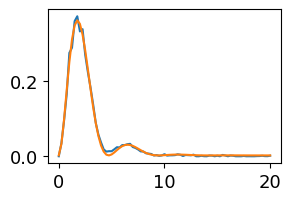

freq:0.10550096420038128,gamma: 0.5344874065590606, amp:1.0755485457831475, phase_deg: 0.9659711088815707,offset: 0.0022869514242090027,
J = 0.71: Angular freq (rad/µs): 0.6628821081571152


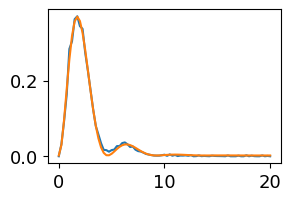

freq:0.10796706785683409,gamma: 0.544760907233695, amp:1.107251342406966, phase_deg: 0.09675918221622617,offset: 0.0021002537453641175,
J = 0.72: Angular freq (rad/µs): 0.6783770944173213


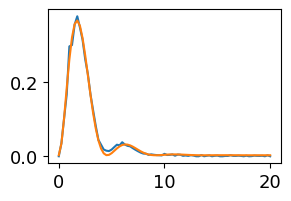

freq:0.1087143886094718,gamma: 0.547865784202359, amp:1.082435502149215, phase_deg: 0.7911867535877419,offset: 0.0027226623674576032,
J = 0.73: Angular freq (rad/µs): 0.683072649190045


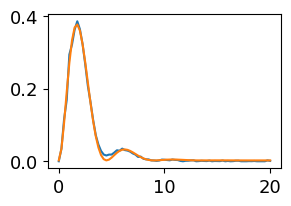

freq:0.11052916884917736,gamma: 0.5563086569020685, amp:1.1223690040797412, phase_deg: 0.5104091916746033,offset: 0.0023836567122042605,
J = 0.74: Angular freq (rad/µs): 0.6944752497279228


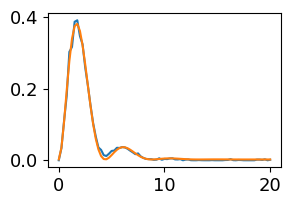

freq:0.11329746358525958,gamma: 0.5435461765101824, amp:1.0834380368300478, phase_deg: 0.5476969150386622,offset: 0.0022364720672914127,
J = 0.75: Angular freq (rad/µs): 0.7118689585396172


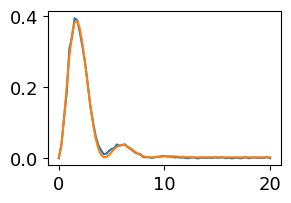

freq:0.11487156181267034,gamma: 0.5493428066883612, amp:1.1006251136865672, phase_deg: 0.595789865911741,offset: 0.0026602900009035286,
J = 0.76: Angular freq (rad/µs): 0.7217593093941419


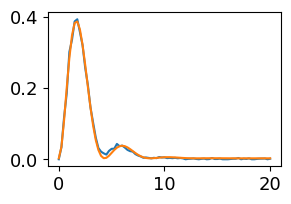

freq:0.1153730202906225,gamma: 0.5514278719566028, amp:1.10309866034561, phase_deg: 0.15590418125657307,offset: 0.0026829884181770337,
J = 0.77: Angular freq (rad/µs): 0.7249100659349716


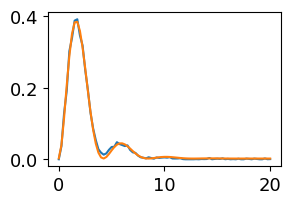

freq:0.11777644648644171,gamma: 0.5174270229983453, amp:1.007614636503966, phase_deg: 1.3039239919470578,offset: 0.002012510256582825,
J = 0.78: Angular freq (rad/µs): 0.7400112380954333


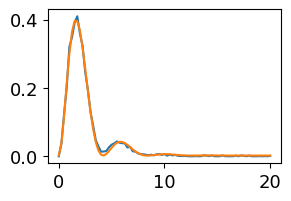

freq:0.11884804116293961,gamma: 0.543669699870842, amp:1.0903125047001667, phase_deg: 0.5485834406779542,offset: 0.00205854246970202,
J = 0.79: Angular freq (rad/µs): 0.7467442660220568


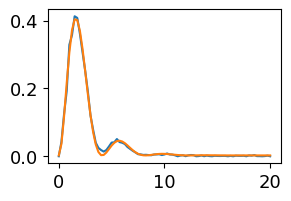

freq:0.12197704309960809,gamma: 0.544364647771432, amp:1.0920953042653272, phase_deg: -0.07875871450335317,offset: 0.002535875254467967,
J = 0.8: Angular freq (rad/µs): 0.7664043650166688


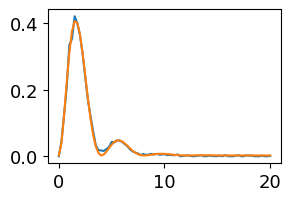

freq:0.12334880512669212,gamma: 0.540056069015652, amp:1.0741015105588891, phase_deg: 0.3415265751111461,offset: 0.0024729059659676037,
J = 0.81: Angular freq (rad/µs): 0.77502340003019


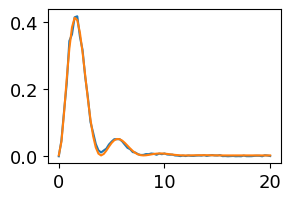

freq:0.12438615949928994,gamma: 0.5283062357008007, amp:1.0550501578808729, phase_deg: 1.0028950825141887,offset: 0.0025338234450646316,
J = 0.8200000000000001: Angular freq (rad/µs): 0.7815412897824351


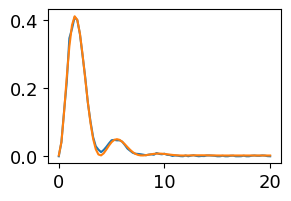

freq:0.12664874677211682,gamma: 0.5431060925007479, amp:1.0623873550766731, phase_deg: 0.5349963260702748,offset: 0.002275301247447231,
J = 0.8300000000000001: Angular freq (rad/µs): 0.7957575448912725


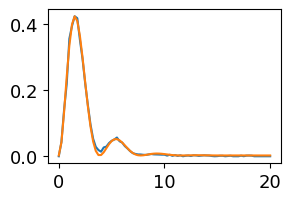

freq:0.12901893250467142,gamma: 0.5509293608748819, amp:1.0904528153375443, phase_deg: 0.23371526032636109,offset: 0.0024420390867631297,
J = 0.84: Angular freq (rad/µs): 0.8106498610613462


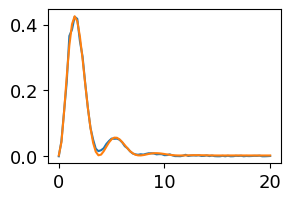

freq:0.13053019370151875,gamma: 0.5343199473488417, amp:1.057443399187489, phase_deg: 0.3311571406049695,offset: 0.0024292823325057842,
J = 0.85: Angular freq (rad/µs): 0.820145395208688


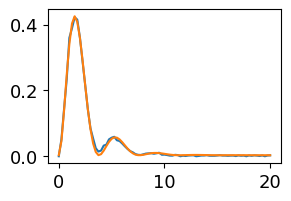

freq:0.1308945229569158,gamma: 0.5361022587763602, amp:1.0493849540201265, phase_deg: 0.7678867339336909,offset: 0.003192228666516391,
J = 0.86: Angular freq (rad/µs): 0.8224345434331745


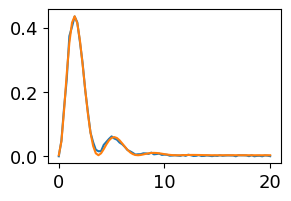

freq:0.1336005326328954,gamma: 0.5433449099574525, amp:1.0733635991420498, phase_deg: 0.41437863586386964,offset: 0.0032164111991549002,
J = 0.87: Angular freq (rad/µs): 0.8394369036703752


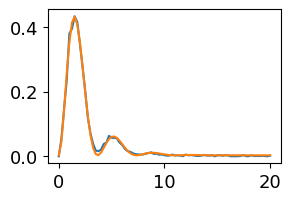

freq:0.13562533753642425,gamma: 0.5403890269625523, amp:1.0508536390656116, phase_deg: 0.29975619103835865,offset: 0.002980500307255054,
J = 0.88: Angular freq (rad/µs): 0.8521591280901328


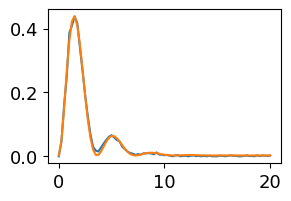

freq:0.13759283942177897,gamma: 0.539498769978656, amp:1.0514337477479838, phase_deg: 0.5663708364118188,offset: 0.002534740420794749,
J = 0.89: Angular freq (rad/µs): 0.8645213070280418


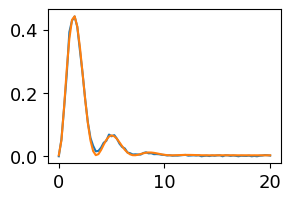

freq:0.13989541175333262,gamma: 0.5445847077036661, amp:1.0557106372679463, phase_deg: 0.5304971656545601,offset: 0.0030680565182981128,
J = 0.9: Angular freq (rad/µs): 0.8789887956703779


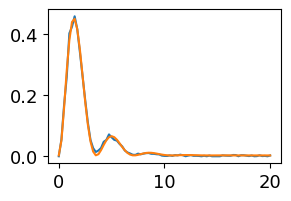

freq:0.14017089033867416,gamma: 0.5506913674025065, amp:1.079950951111078, phase_deg: 0.5912140303060648,offset: 0.0027696914771550246,
J = 0.91: Angular freq (rad/µs): 0.8807196786702385


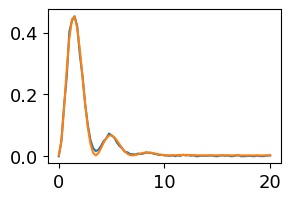

freq:0.1435654702037213,gamma: 0.5553770010239194, amp:1.0853641963486167, phase_deg: -0.2983906767715636,offset: 0.002872265740719603,
J = 0.92: Angular freq (rad/µs): 0.9020484530023503


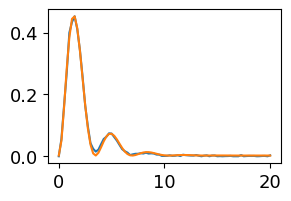

freq:0.14393915272843177,gamma: 0.5324661472128487, amp:1.046116223839266, phase_deg: 0.3422660722416507,offset: 0.002338065613207173,
J = 0.93: Angular freq (rad/µs): 0.904396369551161


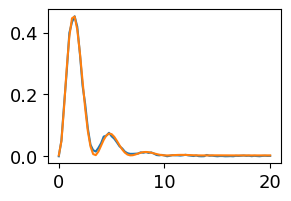

freq:0.1464958549511307,gamma: 0.5431366143681756, amp:1.0539430328136181, phase_deg: -0.2073015812498448,offset: 0.0028027840865740795,
J = 0.9400000000000001: Angular freq (rad/µs): 0.9204606033916564


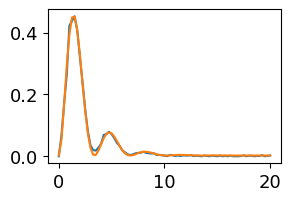

freq:0.14762364129469455,gamma: 0.5316714818442319, amp:1.0266533774457465, phase_deg: 0.4258801939294676,offset: 0.002407451092263153,
J = 0.9500000000000001: Angular freq (rad/µs): 0.9275466939751744


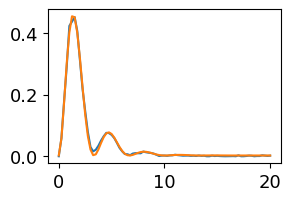

freq:0.14913609915060852,gamma: 0.5379630705201202, amp:1.0281318976731988, phase_deg: 0.9999586396800451,offset: 0.002490034892996716,
J = 0.96: Angular freq (rad/µs): 0.9370497469531814


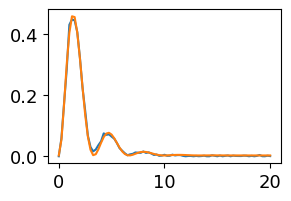

freq:0.15012232346655063,gamma: 0.5475312281582517, amp:1.0568222488202534, phase_deg: 0.22072739286308157,offset: 0.0026812489294356368,
J = 0.97: Angular freq (rad/µs): 0.9432463770846922


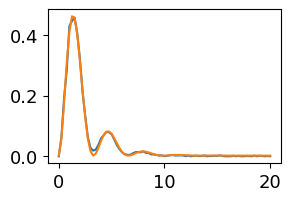

freq:0.15154641568877433,gamma: 0.5308716360128978, amp:1.0252817338141957, phase_deg: 0.8734135900251156,offset: 0.0021076110414166944,
J = 0.98: Angular freq (rad/µs): 0.9521942124114369


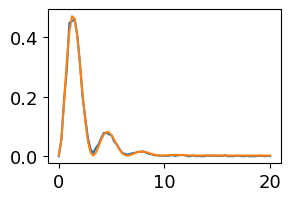

freq:0.15385604429227268,gamma: 0.5462969898040069, amp:1.0581433437187542, phase_deg: 0.2387510980889291,offset: 0.002389341620867928,
J = 0.99: Angular freq (rad/µs): 0.9667060369179793


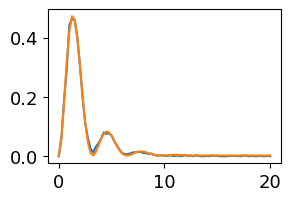

freq:0.155081668430781,gamma: 0.5473714655731807, amp:1.0530571252057785, phase_deg: 0.3056417493682018,offset: 0.002392638836446637,
J = 1.0: Angular freq (rad/µs): 0.9744068604971795


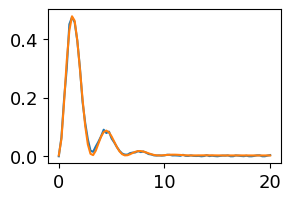

freq:0.15774652218713975,gamma: 0.5448418995532027, amp:1.0480861667996457, phase_deg: 0.1797615917445581,offset: 0.0028235108611803124,
J = 1.01: Angular freq (rad/µs): 0.991150630464915


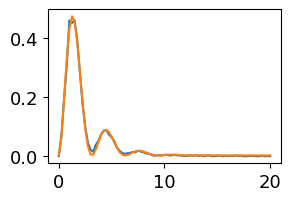

freq:0.15889309327980392,gamma: 0.5383726337259567, amp:1.01368805397289, phase_deg: 0.8871857131157612,offset: 0.0028186680314315734,
J = 1.02: Angular freq (rad/µs): 0.9983547491079794


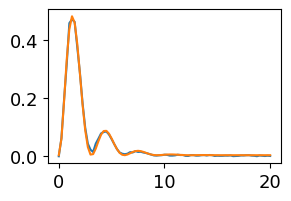

freq:0.16123016444978402,gamma: 0.5573629056524536, amp:1.0598171869003385, phase_deg: -0.12028331142725275,offset: 0.0036666232301843997,
J = 1.03: Angular freq (rad/µs): 1.0130390003450314


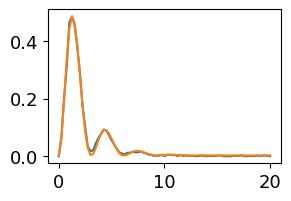

freq:0.1621241486428322,gamma: 0.5489100147989079, amp:1.0492475760007838, phase_deg: 0.09085100855030233,offset: 0.002728203242590452,
J = 1.04: Angular freq (rad/µs): 1.0186560686916426


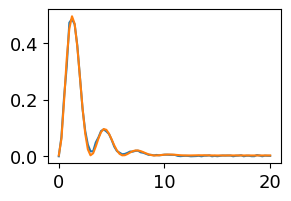

freq:0.16412631442073905,gamma: 0.5438015486059591, amp:1.0524058204934812, phase_deg: -0.11454829130197945,offset: 0.002897240651771194,
J = 1.05: Angular freq (rad/µs): 1.0312360472899247


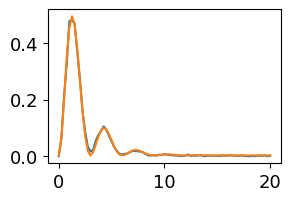

freq:0.16637536430975786,gamma: 0.5386664557722971, amp:1.0324471686549281, phase_deg: 0.11679399496138157,offset: 0.002976420538652558,
J = 1.06: Angular freq (rad/µs): 1.0453672445077216


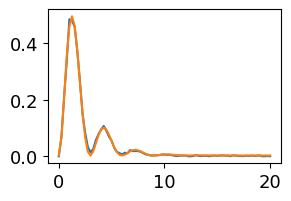

freq:0.16738628705839653,gamma: 0.5375854348085646, amp:1.0299439389522034, phase_deg: 0.3115596041485535,offset: 0.002748340792618571,
J = 1.07: Angular freq (rad/µs): 1.0517190594686616


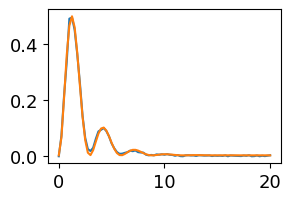

freq:0.16980423050534982,gamma: 0.5452258276276196, amp:1.0345203046740106, phase_deg: 0.19229510515845213,offset: 0.0033351348325174244,
J = 1.08: Angular freq (rad/µs): 1.0669114462081497


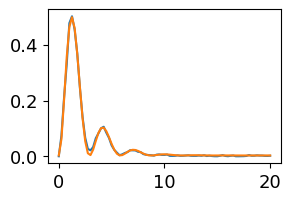

freq:0.17169639529371764,gamma: 0.547027828429271, amp:1.0387434553403365, phase_deg: -0.6799129965371904,offset: 0.0028694975149453636,
J = 1.09: Angular freq (rad/µs): 1.078800268205185


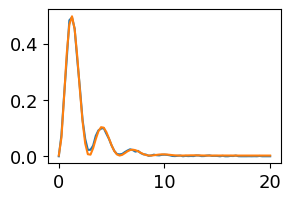

freq:0.17359057535069075,gamma: 0.5485807080657167, amp:1.0265524594089308, phase_deg: -0.17671542642345392,offset: 0.00252798500305938,
J = 1.1: Angular freq (rad/µs): 1.090701752508311


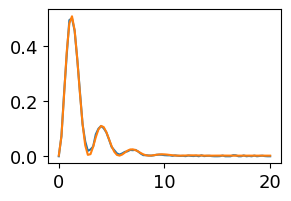

freq:0.17494406045028202,gamma: 0.5397906253032682, amp:1.0298172414603615, phase_deg: 0.47647670499291733,offset: 0.0022764388335721982,
J = 1.11: Angular freq (rad/µs): 1.0992059501995493


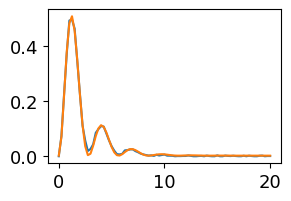

freq:0.1763963821645965,gamma: 0.5370561354551466, amp:1.0258111808104602, phase_deg: 0.20464463356339488,offset: 0.0022286116244020723,
J = 1.12: Angular freq (rad/µs): 1.108331156656228


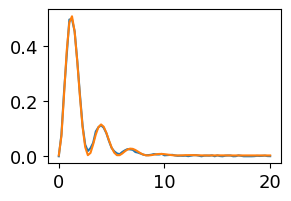

freq:0.17764870719571954,gamma: 0.5352499930142226, amp:1.0165015772162778, phase_deg: 0.3985116726269795,offset: 0.003012153606148555,
J = 1.1300000000000001: Angular freq (rad/µs): 1.1161997468915934


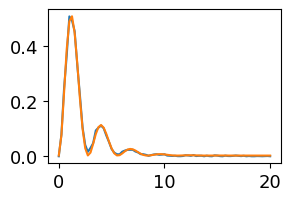

freq:0.1784771070848682,gamma: 0.5435229620726756, amp:1.0250448602296713, phase_deg: 0.713993811223677,offset: 0.0025345400619459875,
J = 1.1400000000000001: Angular freq (rad/µs): 1.1214047369035613


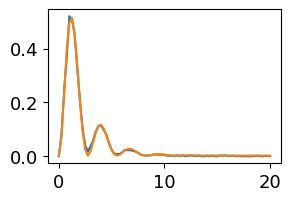

freq:0.1813576057249692,gamma: 0.5451566724173224, amp:1.0364102139819056, phase_deg: -0.06248878254789453,offset: 0.0024468213432218434,
J = 1.1500000000000001: Angular freq (rad/µs): 1.1395034436363949


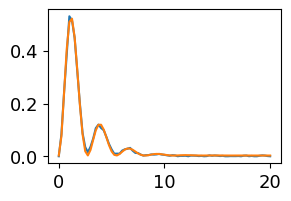

freq:0.18404250006225825,gamma: 0.5455205618360588, amp:1.041973719485328, phase_deg: 0.014709700412071511,offset: 0.0028201552635738533,
J = 1.16: Angular freq (rad/µs): 1.156373132287779


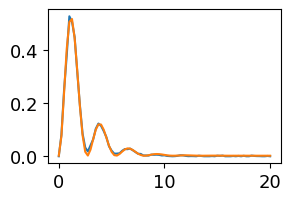

freq:0.18466324121355893,gamma: 0.54136324361592, amp:1.0254357403871044, phase_deg: 0.1494940300455227,offset: 0.0021098701994346387,
J = 1.17: Angular freq (rad/µs): 1.1602733639691933


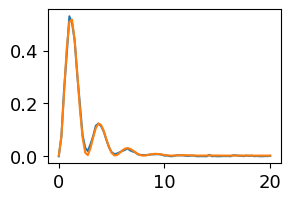

freq:0.18727013486377928,gamma: 0.5453009341366071, amp:1.02956076973743, phase_deg: -0.27802793188636626,offset: 0.002624345797110701,
J = 1.18: Angular freq (rad/µs): 1.1766529598496376


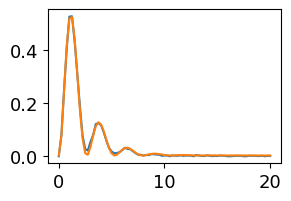

freq:0.18901297817572493,gamma: 0.5458912812086059, amp:1.0427141812540468, phase_deg: -0.40057376098752445,offset: 0.0029046731445850947,
J = 1.19: Angular freq (rad/µs): 1.1876035673399707


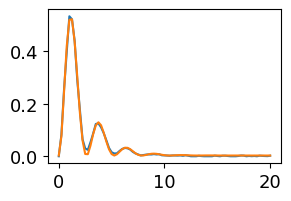

freq:0.1909889580211139,gamma: 0.54708269091388, amp:1.0363209396665207, phase_deg: -0.4727237490127612,offset: 0.0028195031546227605,
J = 1.2: Angular freq (rad/µs): 1.2000190148718017


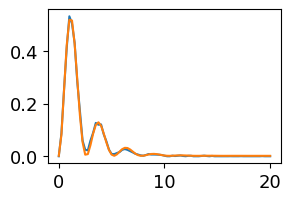

freq:0.19139335315314324,gamma: 0.5436789123214721, amp:1.0176455688818038, phase_deg: 0.3020742727427373,offset: 0.0016882924356555677,
J = 1.21: Angular freq (rad/µs): 1.2025599044236632


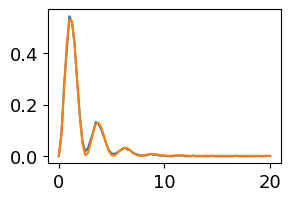

freq:0.1940193850886193,gamma: 0.5525701437916897, amp:1.045011696050146, phase_deg: -0.12296543224315674,offset: 0.0017565220564879963,
J = 1.22: Angular freq (rad/µs): 1.219059749696831


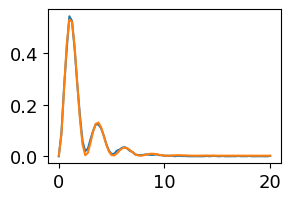

freq:0.19459755697966669,gamma: 0.5527829182735686, amp:1.0399023720993703, phase_deg: -0.010763659884844942,offset: 0.0022659136260107485,
J = 1.23: Angular freq (rad/µs): 1.222692510827684


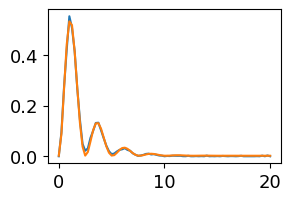

freq:0.1964851671631464,gamma: 0.5535576745465178, amp:1.032811639544971, phase_deg: 0.41571157307209317,offset: 0.0021025923720439602,
J = 1.24: Angular freq (rad/µs): 1.2345527153982063


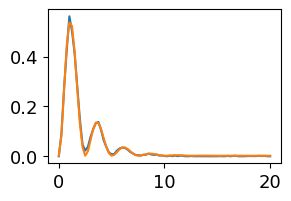

freq:0.19826248729482135,gamma: 0.5491486647040938, amp:1.0343729812482438, phase_deg: -0.22543528578941222,offset: 0.0021366213973772435,
J = 1.25: Angular freq (rad/µs): 1.245719947135701


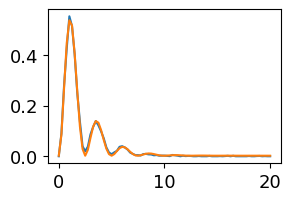

freq:0.20092596963957887,gamma: 0.5489549808787784, amp:1.0245931888614774, phase_deg: -0.18303876905074729,offset: 0.0022522729149574523,
J = 1.26: Angular freq (rad/µs): 1.2624551002702136


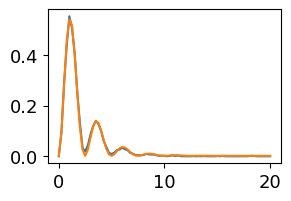

freq:0.20070571536818027,gamma: 0.5504622391935186, amp:1.027343962502653, phase_deg: 0.5048912750839871,offset: 0.001750246431869098,
J = 1.27: Angular freq (rad/µs): 1.2610712018683183


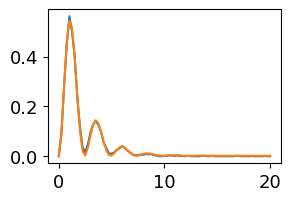

freq:0.20388993679389888,gamma: 0.5482429430378349, amp:1.023498965143655, phase_deg: -0.027898705885305432,offset: 0.0018797467547258207,
J = 1.28: Angular freq (rad/µs): 1.2810782551452


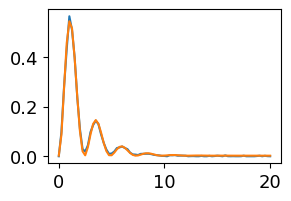

freq:0.2053588736766332,gamma: 0.5487478620679094, amp:1.0229610792172041, phase_deg: -0.484676150667862,offset: 0.0024186614637685564,
J = 1.29: Angular freq (rad/µs): 1.2903078577839704


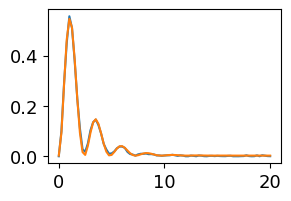

freq:0.20647785106833397,gamma: 0.548163314415876, amp:1.0128300048442334, phase_deg: 0.19720695508768654,offset: 0.002640945924944909,
J = 1.3: Angular freq (rad/µs): 1.297338600090571


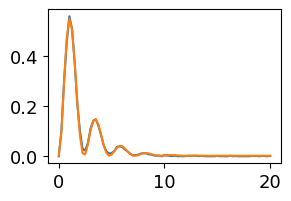

freq:0.20837910324681969,gamma: 0.5466397054140129, amp:1.0108798546499784, phase_deg: 0.5721163378183766,offset: 0.002034717518962401,
J = 1.31: Angular freq (rad/µs): 1.3092845198436756


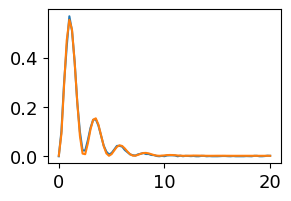

freq:0.21044211818445227,gamma: 0.5383334756240555, amp:1.0086036282652264, phase_deg: -0.3601608514331071,offset: 0.001959447256689983,
J = 1.32: Angular freq (rad/µs): 1.3222468249883006


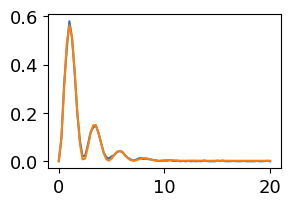

freq:0.2125700718836805,gamma: 0.5582480301074385, amp:1.0357280373102822, phase_deg: -0.08869750920455352,offset: 0.0021489044785908966,
J = 1.33: Angular freq (rad/µs): 1.3356171524056497


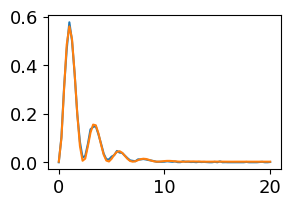

freq:0.21404094329017564,gamma: 0.5454214249696213, amp:1.0127949301207686, phase_deg: 0.06885819465013882,offset: 0.0024233402446231242,
J = 1.34: Angular freq (rad/µs): 1.3448589100156907


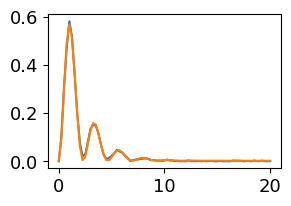

freq:0.21608189492732394,gamma: 0.5513891194513304, amp:1.0323341701852584, phase_deg: -0.44846649399384114,offset: 0.002194778836814942,
J = 1.35: Angular freq (rad/µs): 1.357682587354885


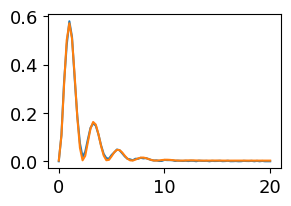

freq:0.2172819594637719,gamma: 0.5488840285209249, amp:1.0242010329085847, phase_deg: 0.37008977998078785,offset: 0.002755246055956975,
J = 1.36: Angular freq (rad/µs): 1.3652228152179622


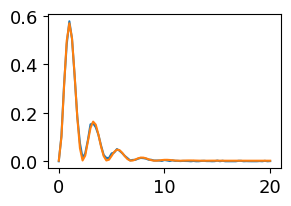

freq:0.2186884322543033,gamma: 0.5484019224959242, amp:1.0239443287575491, phase_deg: -0.36293025751149605,offset: 0.002337913197119898,
J = 1.37: Angular freq (rad/µs): 1.3740599443903767


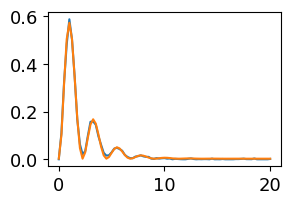

freq:0.22109157607775967,gamma: 0.5474595312497827, amp:1.0223878166665898, phase_deg: -0.277711854123521,offset: 0.002449129639831529,
J = 1.3800000000000001: Angular freq (rad/µs): 1.3891593423529573


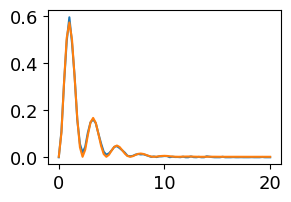

freq:0.22227836950599433,gamma: 0.5511333426573121, amp:1.024975679699056, phase_deg: -0.19004013539572379,offset: 0.002092327937034426,
J = 1.3900000000000001: Angular freq (rad/µs): 1.3966161853838985


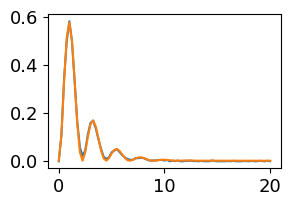

freq:0.2236980242634275,gamma: 0.5513621085108678, amp:1.0240224069736972, phase_deg: 0.10778215358708737,offset: 0.002339193388018668,
J = 1.4000000000000001: Angular freq (rad/µs): 1.4055361392970702


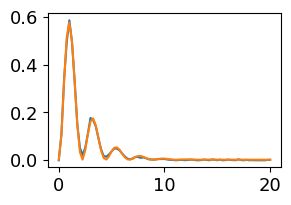

freq:0.22559885375998728,gamma: 0.5394071668693835, amp:1.0094828073543776, phase_deg: -0.177045679212988,offset: 0.0023708466971735123,
J = 1.41: Angular freq (rad/µs): 1.4174794032613083


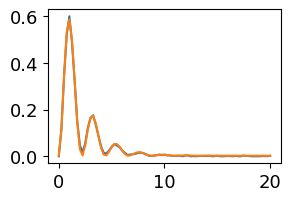

freq:0.22668247136264455,gamma: 0.5515005743128771, amp:1.0356836301552284, phase_deg: 0.39523206469723043,offset: 0.00236801094489181,
J = 1.42: Angular freq (rad/µs): 1.4242879734609255


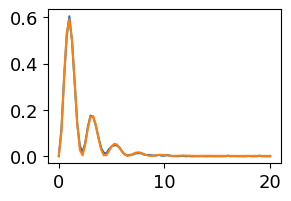

freq:0.22965111930093343,gamma: 0.555487156917366, amp:1.0471134053367697, phase_deg: -0.7620256136902502,offset: 0.0016625568432107464,
J = 1.43: Angular freq (rad/µs): 1.4429405385689713


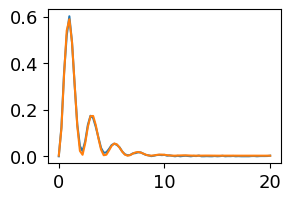

freq:0.22971597736922564,gamma: 0.5546456112197313, amp:1.0348394561886767, phase_deg: 0.45420548620090184,offset: 0.0025795066692106457,
J = 1.44: Angular freq (rad/µs): 1.4433480538307168


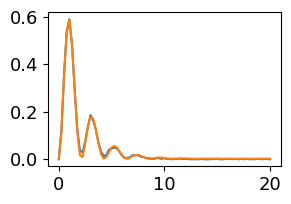

freq:0.233007861284016,gamma: 0.5555256212261765, amp:1.033744809232696, phase_deg: 0.10442473741375055,offset: 0.002283611300332967,
J = 1.45: Angular freq (rad/µs): 1.4640315704770683


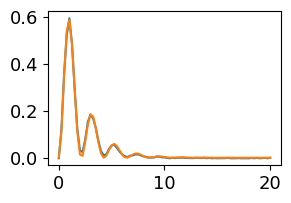

freq:0.23412029646527174,gamma: 0.5394250652598194, amp:1.014163360227857, phase_deg: -0.15397322679544725,offset: 0.0022029169359739755,
J = 1.46: Angular freq (rad/µs): 1.4710212068631243


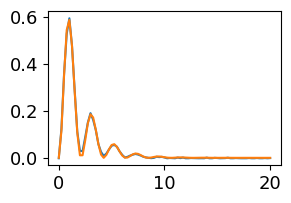

freq:0.23595132792560755,gamma: 0.5446655733052111, amp:1.0177537669274892, phase_deg: -0.08970466211187383,offset: 0.0018719799247961131,
J = 1.47: Angular freq (rad/µs): 1.4825259168316898


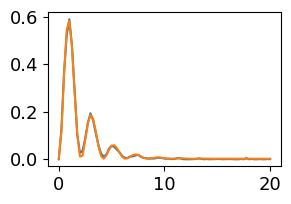

freq:0.2369691482864161,gamma: 0.5480964194351765, amp:1.0162144614277384, phase_deg: -0.009484122381608624,offset: 0.002228033178552595,
J = 1.48: Angular freq (rad/µs): 1.4889210707680702


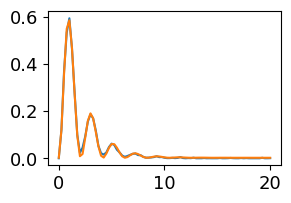

freq:0.23886531735991146,gamma: 0.5453971195590904, amp:1.010263536764029, phase_deg: -0.005040389174899388,offset: 0.0021240038480700558,
J = 1.49: Angular freq (rad/µs): 1.5008350524305847


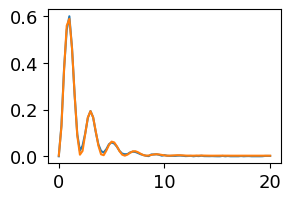

freq:0.2406768730620365,gamma: 0.5484282606628947, amp:1.0197345776996136, phase_deg: 0.28417289781354504,offset: 0.0025182939564872627,
J = 1.5: Angular freq (rad/µs): 1.512217392601314
J = 0.0: omega = 0.06283185307160849 rad/µs
J = 0.01: omega = 0.0628318516604966 rad/µs
J = 0.02: omega = 0.06283185300839204 rad/µs
J = 0.03: omega = 0.00246190887235464 rad/µs
J = 0.04: omega = 0.005900827791106497 rad/µs
J = 0.05: omega = 0.00655165673958197 rad/µs
J = 0.06: omega = 0.007389805527881708 rad/µs
J = 0.07: omega = 0.008762513557171217 rad/µs
J = 0.08: omega = 0.011450600018830803 rad/µs
J = 0.09: omega = 0.012221713308683867 rad/µs
J = 0.1: omega = 0.014558156174760915 rad/µs
J = 0.11: omega = 0.01585303416571232 rad/µs
J = 0.12: omega = 0.01825013921481919 rad/µs
J = 0.13: omega = 0.01971399425662777 rad/µs
J = 0.14: omega = 0.021162573763093894 rad/µs
J = 0.15: omega = 0.02324314338063456 rad/µs
J = 0.16: omega = 0.024408368471256582 rad/µs
J = 0.17: omega = 0.02784466700264838 rad/µ

In [20]:
# probability_dataframes = 0
omega_dict = sweep_J_curve_fit(probability_dataframes)

# Print the results
for J, omega in omega_dict.items():
    print(f"J = {J}: omega = {omega} rad/µs")
J_vals = sorted(omega_dict.keys())
omegas = [omega_dict[J] for J in J_vals]




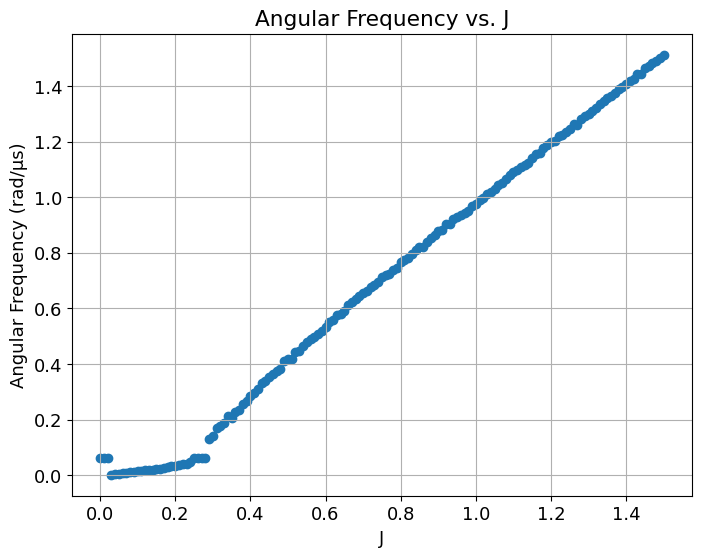

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(J_vals, omegas, marker="o")
plt.xlabel("J")
plt.ylabel("Angular Frequency (rad/µs)")
plt.title("Angular Frequency vs. J")
plt.grid(True)
plt.show()

In [31]:
def fit_func(J, A, J0):
    """
    Model function: Re(A * sqrt(J - J0^2)).
    
    For each value in J, computes A*sqrt(J - J0^2) if J - J0^2 is nonnegative;
    otherwise returns 0.
    
    Parameters:
        J : array_like
            The independent variable.
        A : float
            Amplitude scaling factor.
        J0 : float
            Parameter inside the square root.
    
    Returns:
        array_like : The computed model values.
    """
    expr = J**2 - J0**2
    return np.where(expr >= 0, A * np.sqrt(expr), 0.0)

def curve_fit_function(J_data, y_data, initial_guess_A=1.0, initial_guess_J0=1.0):
    """
    Fits the data (J_data, y_data) to the function
         f(J) = Re(A * sqrt(J - J0^2))
    using the provided initial guesses for A and J0.
    
    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_A : float, optional
            Initial guess for the amplitude A (default is 1.0).
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).
    
    Returns:
        popt : ndarray
            Optimal values for the parameters [A, J0].
        pcov : 2D ndarray
            The estimated covariance of popt.
    """
    popt, pcov = curve_fit(fit_func, J_data, y_data, p0=[initial_guess_A, initial_guess_J0])
    return popt, pcov

def curve_fit_and_plot(J_data, y_data, initial_guess_A=1.0, initial_guess_J0=1.0):
    """
    Fits the given data to the model function f(J) = Re(A * sqrt(J - J0^2))
    and plots the original data (as a scatter plot) along with the fitted curve.
    
    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_A : float, optional
            Initial guess for the amplitude A (default is 1.0).
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).
    
    Returns:
        popt : ndarray
            The optimal parameters [A, J0] from the curve fitting.
        pcov : 2D ndarray
            The covariance matrix of the fitted parameters.
    """
    # Perform the curve fit
    popt, pcov = curve_fit_function(J_data, y_data, initial_guess_A, initial_guess_J0)
    fitted_A, fitted_J0 = popt
    print("Fitted A =", fitted_A)
    print("Fitted J0 =", fitted_J0)
    
    # Generate a smooth set of points for plotting the fitted curve
    J_fit = np.linspace(np.min(J_data), np.max(J_data), 1000)
    y_fit = fit_func(J_fit, fitted_A, fitted_J0)
    
    # Create the plot: scatter for original data and line for fitted curve
    plt.figure(figsize=(8, 5))
    plt.plot(J_fit, y_fit, label="Fitted Curve", color="red", linewidth=2)
    plt.scatter(J_data, y_data, label="Original Data", color="blue", s=30, alpha = .5)
    plt.xlabel("J")
    plt.ylabel("alpha=Re(A * sqrt(J^2 - J0^2))")
    plt.title("alpha vs J")
    plt.legend()
    # plt.grid(True)
    plt.show()
    
    return popt, pcov
def fit_func_fixed_A(J, J0):
    """
    Model function: Re(sqrt(J^2 - J0^2)), with A fixed at 1.
    """
    expr = J**2 - J0**2
    return np.where(expr >= 0, np.sqrt(expr), 0.0)
def curve_fit_and_plot_fixed_A(J_data, y_data, initial_guess_J0=1.0):
    """
    Fits the given data to the model function f(J) = Re(sqrt(J^2 - J0^2)), with A fixed at 1.
    """
    # Only fit for J0
    popt, pcov = curve_fit(fit_func_fixed_A, J_data, y_data, p0=[initial_guess_J0])
    fitted_J0 = popt[0]
    print("Fitted J0 =", fitted_J0)
    
    # Generate a smooth set of points for plotting the fitted curve
    J_fit = np.linspace(np.min(J_data), np.max(J_data), 1000)
    y_fit = fit_func_fixed_A(J_fit, fitted_J0)
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(J_fit, y_fit, label="Fitted Curve (A=1)", color="red", linewidth=2)
    plt.scatter(J_data, y_data, label="Original Data", color="blue", s=30, alpha=0.5)
    plt.xlabel("J")
    plt.ylabel(r"alpha = \mathrm{Re}(\sqrt{J^2 - J_0^2})")
    plt.title("alpha vs J (A fixed at 1)")
    plt.legend()
    plt.show()
    
    return popt, pcov

C:\Users\quantum1\AppData\Local\Temp\ipykernel_14112\711064624.py:95: RuntimeWarning: invalid value encountered in sqrt
  return np.where(expr >= 0, np.sqrt(expr), 0.0)


Fitted J0 = 0.2623326664269155


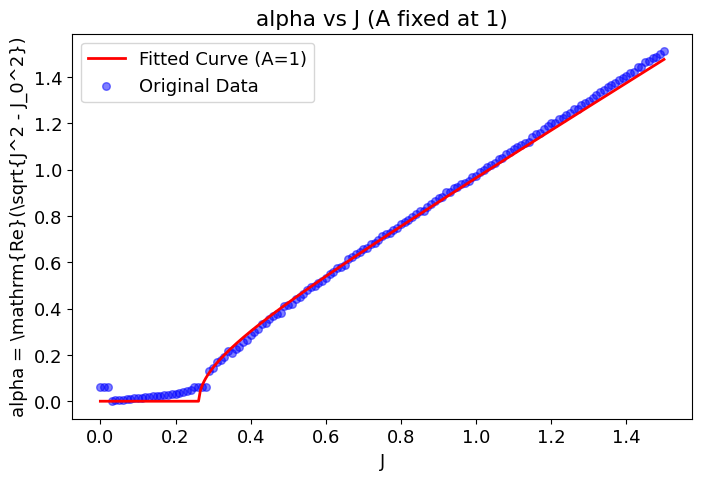

In [32]:
# Set initial guesses based on your expectations:
mask_rb = ~np.isnan(omegas)
# Assuming J_vals and omegas are defined and mask_rb selects the non-NaN entries.
J_vals_array = np.array(J_vals)[mask_rb]
omegas_array = np.array(omegas)[mask_rb]

# Set your initial guess values
initial_guess_J0 = 0.26# for example
initial_guess_A0 = 1
# Now, call your curve fitting and plotting function with the first 100 data points.
popt, pcov = curve_fit_and_plot_fixed_A(J_vals_array, omegas_array, initial_guess_J0)



<Figure size 960x720 with 0 Axes>

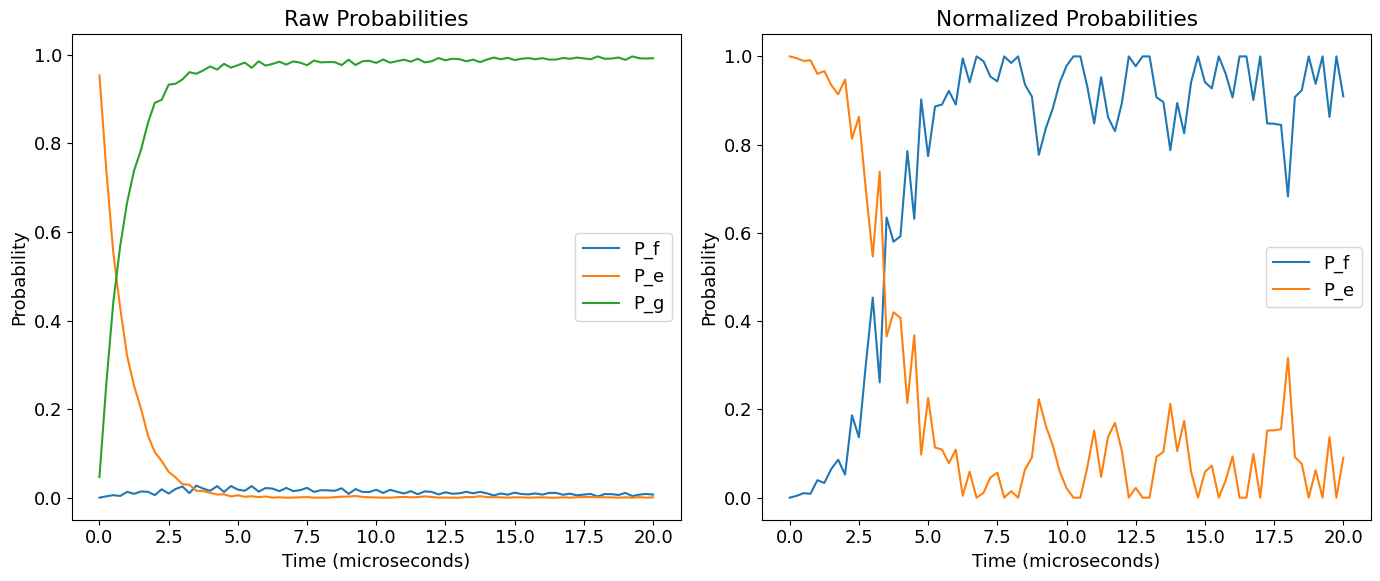

In [13]:
J = 0.1
df = probability_dataframes[J]  # This is your DataFrame for J=2

# Assuming probability_dataframes is the DataFrame loaded for J=2
# Extract the raw probabilities into an array (if needed)
measured_pop = np.array([
    df["P_g"],
    df["P_e"],
    df["P_f"]
])

# Compute normalization factor (using P_f and P_e)
normalization_val = df["P_f"] + df["P_e"]

# Create a new DataFrame with normalized probabilities
normalized_df = pd.DataFrame({
    "time": df["time"],
    "P_f": df["P_f"] / normalization_val,
    "P_e": df["P_e"] / normalization_val,
    "P_g": df["P_g"] / normalization_val,
})

# List of keys to plot
keys = ["P_f", "P_e", "P_g"]

# Create figure and two subplots
plt.figure(dpi=150)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot raw probabilities in the first subplot
for key in keys:
    sns.lineplot(data=df, x="time", y=key, ax=axes[0], label=key)

# Plot normalized probabilities in the second subplot (skip "P_g" if desired)
for key in keys:
    if key != "P_g":  # Plot only P_f and P_e for normalization if that’s your intention
        sns.lineplot(data=normalized_df, x="time", y=key, ax=axes[1], label=key)

# Set labels and titles for clarity
axes[0].set_xlabel("Time (microseconds)")
axes[0].set_ylabel("Probability")
axes[0].set_title("Raw Probabilities")
axes[0].legend()

axes[1].set_xlabel("Time (microseconds)")
axes[1].set_ylabel("Probability")
axes[1].set_title("Normalized Probabilities")
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



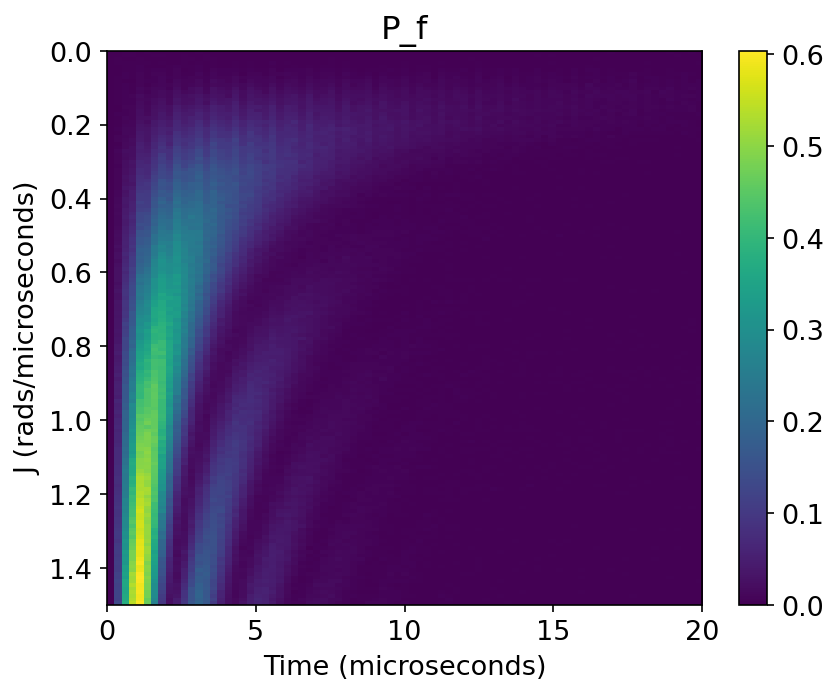

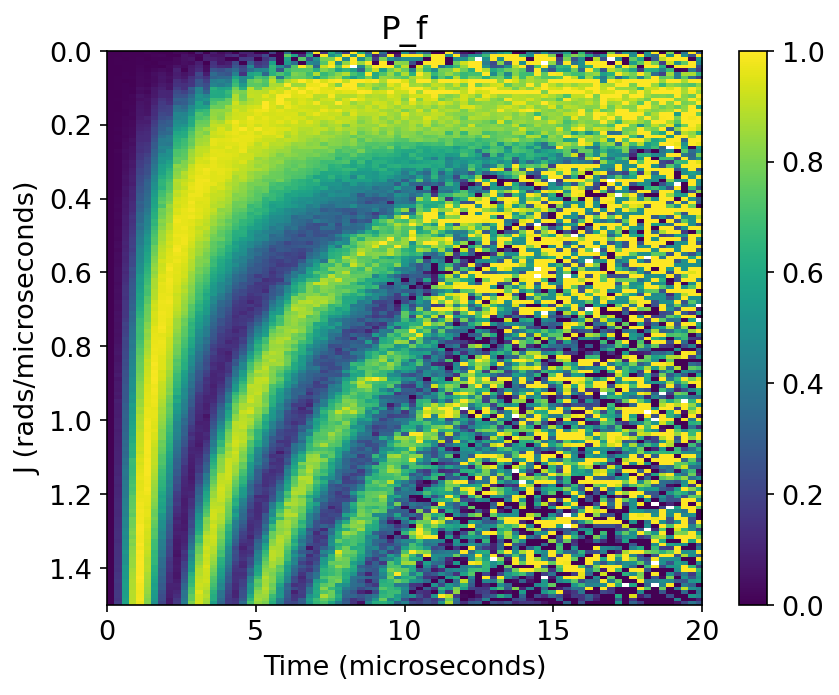

In [14]:
# Define parameters
num_steps = 81
sweep_time = 20000  # in microseconds
J_start = 0        # starting J value
J_stop = 1.5       # ending J value
J_steps = 151       # number of J values

# Generate an array of J values
J_vals = np.linspace(J_start, J_stop, J_steps)

# Initialize a 2D array to store normalized P_f values
p_f = np.zeros((J_steps, num_steps))
p_f_norm = np.zeros((J_steps, num_steps))
# Loop over each J value, and calculate the normalized P_f
for i, J in enumerate(J_vals):
    # probs_folder = os.path.join("sweep_J_data", "probs")
    # pkl_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")

    # with open(pkl_filename, "rb") as f:
    #     probability_dataframes = pickle.load(f)

      # This is your DataFrame for J=2
    # Access the DataFrame for the current J
    df = probability_dataframes[J]
    
    # Compute normalized P_f using P_f / (P_f + P_e)
    p_f[i] = df["P_f"] #/ (df["P_f"] + df["P_e"])
    p_f_norm[i] = df["P_f"] / (df["P_f"] + df["P_e"])

# Create the 2D plot
plt.figure(dpi=150)
# extent: [x_min, x_max, y_min, y_max] where time is on x and J on y.
plt.imshow(p_f, extent=[0, sweep_time / 1000, J_stop, J_start], aspect="auto")
plt.colorbar()
plt.ylabel("J (rads/microseconds)")
plt.xlabel("Time (microseconds)")
plt.title("P_f")
plt.show()

plt.figure(dpi=150)
# extent: [x_min, x_max, y_min, y_max] where time is on x and J on y.
plt.imshow(p_f_norm, extent=[0, sweep_time / 1000, J_stop, J_start], aspect="auto")
plt.colorbar()
plt.ylabel("J (rads/microseconds)")
plt.xlabel("Time (microseconds)")
plt.title("P_f")
plt.show()

In [15]:
probability_dataframes

{0.0:         time           P_f       P_e       P_g
 time                                          
 0.00    0.00  8.673617e-19  0.956365  0.043635
 0.25    0.25  2.215988e-03  0.740978  0.256806
 0.50    0.50  3.514338e-03  0.563111  0.433375
 0.75    0.75  2.514030e-03  0.430807  0.566679
 1.00    1.00  1.892173e-03  0.341474  0.656634
 ...      ...           ...       ...       ...
 19.00  19.00  2.603630e-03  0.000648  0.996748
 19.25  19.25  0.000000e+00  0.001409  0.998591
 19.50  19.50  1.363904e-03  0.002237  0.996399
 19.75  19.75  2.509137e-03  0.000000  0.997491
 20.00  20.00  8.396671e-04  0.002327  0.996833
 
 [81 rows x 4 columns],
 0.01:         time           P_f           P_e       P_g
 time                                              
 0.00    0.00  0.000000e+00  9.556072e-01  0.044393
 0.25    0.25  1.156449e-03  7.286643e-01  0.270179
 0.50    0.50  3.350787e-03  5.638726e-01  0.432777
 0.75    0.75  3.319918e-03  4.284778e-01  0.568202
 1.00    1.00  1.966551e-03

<Figure size 960x720 with 0 Axes>

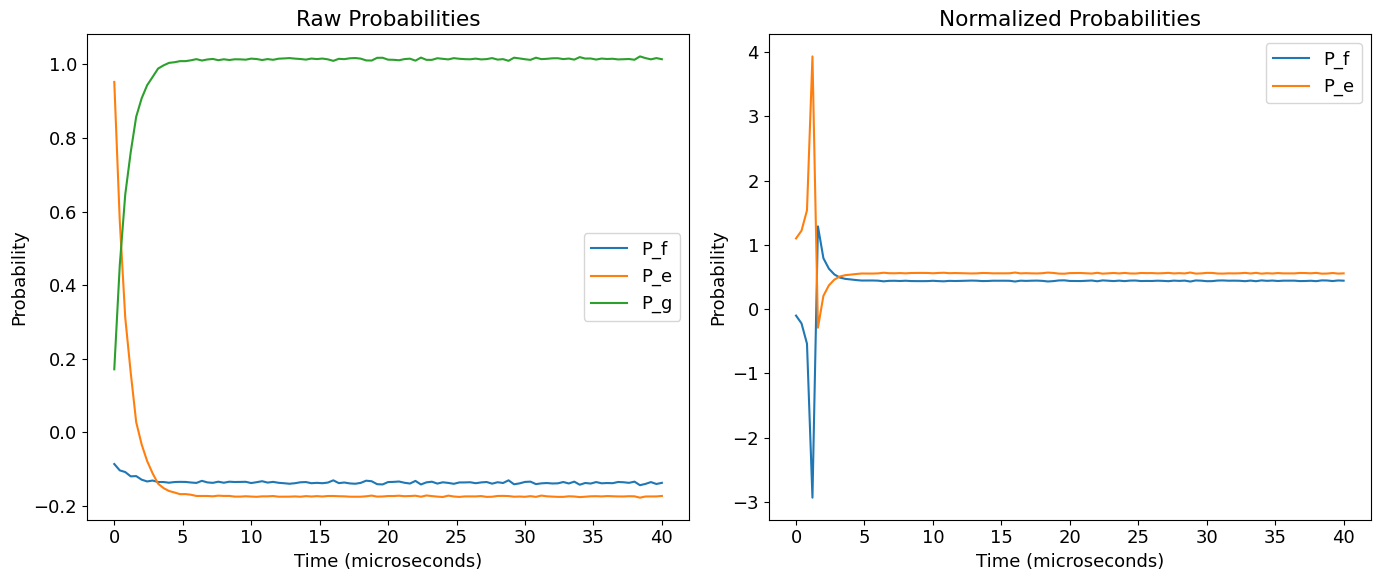

In [ ]:
scale_matrix = np.array([
    [0.96513333, 0.00563333, 0.02923333],
    [0.14921667, 0.8369,     0.01388333],
    [0.14105,    0.05938333, 0.79956667]
])
inv_matrix = np.linalg.inv(scale_matrix)
scaled_pop =np.matmul(inv_matrix,measured_pop )
scaled_df = pd.DataFrame({
    "time": probability_dataframes["time"],
    "P_f": scaled_pop[2],
    "P_e": scaled_pop[1],
    "P_g": scaled_pop[0],
})
# Compute normalization factor (using P_f and P_e)
normalization_val_scaled = scaled_pop[1]+scaled_pop[2]

# Create a new DataFrame with normalized probabilities
normalized_scaled_df = pd.DataFrame({
    "time": probability_dataframes["time"],
    "P_f": scaled_pop[2]/normalization_val_scaled,
    "P_e": scaled_pop[1]/normalization_val_scaled,
    "P_g": scaled_pop[0]/normalization_val_scaled,
})
# List of keys to plot
keys = ["P_f", "P_e", "P_g"]

# Create figure and two subplots
plt.figure(dpi=150)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot raw probabilities in the first subplot
for key in keys:
    sns.lineplot(data=scaled_df, x="time", y=key, ax=axes[0], label=key)

# Plot normalized probabilities in the second subplot (skip "P_g" if desired)
for key in keys:
    if key != "P_g":  # Plot only P_f and P_e for normalization if that’s your intention
        sns.lineplot(data=normalized_scaled_df, x="time", y=key, ax=axes[1], label=key)

# Set labels and titles for clarity
axes[0].set_xlabel("Time (microseconds)")
axes[0].set_ylabel("Probability")
axes[0].set_title("Raw Probabilities")
axes[0].legend()

axes[1].set_xlabel("Time (microseconds)")
axes[1].set_ylabel("Probability")
axes[1].set_title("Normalized Probabilities")
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
# Initialize a dictionary to store the probability DataFrames for each J value
probability_dataframes = {}

# Loop over each J value and load the corresponding pickle file if it exists
for J in J_list:
    prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
    values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")
    
    if os.path.exists(prob_filename) and os.path.exists(values_filename):
        with open(prob_filename, "rb") as f:
            df_prob = pickle.load(f)
        probability_dataframes[J] = df_prob
    else:
        print(f"Data for J = {J:.3f} not found. Skipping.")

# ---------------------------
# 2. Prepare Data for 2D Plotting
# ---------------------------

# Define parameters for the sweep
num_steps = 51      # number of time steps (should match what you used when saving the data)
sweep_time = 20000  # total sweep time in microseconds

# Initialize a 2D array to hold the normalized P_f values
p_f = np.zeros((J_steps, num_steps))

# For each J value, compute the normalized P_f as P_f / (P_f + P_e)
for i, J in enumerate(J_list):
    df = probability_dataframes.get(J)
    if df is not None:
        # Compute normalized P_f
        p_f[i] = df["P_f"] / (df["P_f"] + df["P_e"])
    else:
        # Fill with NaN if data is missing for a specific J
        p_f[i] = np.nan

# ---------------------------
# 3. Create the 2D Plot
# ---------------------------

plt.figure(dpi=150)
# The extent parameter maps the array indices to real data coordinates:
# [x_min, x_max, y_min, y_max]
plt.imshow(p_f, extent=[0, sweep_time/1000, J_stop, J_start], aspect="auto")
plt.colorbar(label="Normalized P_f")
plt.xlabel("Time (microseconds)")
plt.ylabel("J (rads/microseconds)")
plt.title("2D Heatmap of Normalized P_f vs Time and J")
plt.show()

ValueError: could not broadcast input array from shape (101,) into shape (51,)